In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Posterior Predictive Model Checking

### 1.1 Observed score distribution

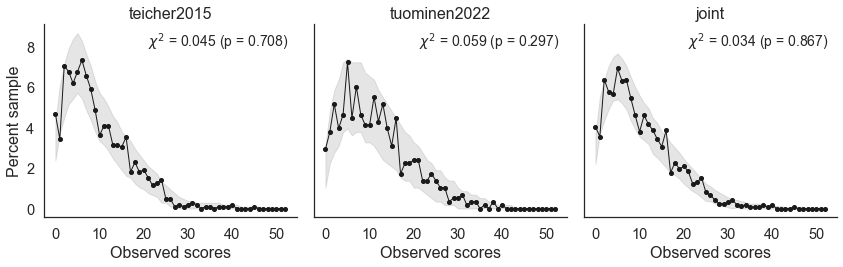

In [2]:
from arviz import hdi

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
studies = ['teicher2015','tuominen2022','joint']

for i, (ax, study) in enumerate(zip(axes, studies)):

    ## Load posterior predictive check.
    df = read_csv(os.path.join('stan_results', study, '2plq_m2_ppmc1.csv'), index_col=0)
    
    ## Normalize counts across samples.
    df.loc[:,:] /= df.loc[0].values.sum()
    
    ## Extract values.
    NC  = df.values[0]
    NCr = df.values[1:]
    ENC = NCr.mean(axis=0)
    
    ## Compute 95% HDI.
    lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)
    
    ## Compute chi-square statistics.
    xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
    xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)
    
    ## Compute ppp-value.
    pppv = (xi >= xr).mean()

    ## Plot observed scores and 95% HDI.
    ax.plot(np.arange(NC.size), NC, 'o-', color='k', lw=1, markersize=4)    
    ax.fill_between(np.arange(NC.size), lb, ub, color='0.5', alpha=0.2)
    
    ## Add detail.
    ax.set(xticks=np.arange(0,51,10), xlabel='Observed scores', yticks=np.arange(0,0.09,0.02), 
           yticklabels=np.arange(0,9,2), ylabel='', title=study)
    if not i: ax.set_ylabel('Percent sample')
    
    ## Add annotations.
    ax.annotate(r'$\chi^2$ = %0.3f (p = %0.3f)' %(xi, pppv), (0,0), (0.97, 0.97), 
                xycoords='axes fraction', ha='right', va='top', fontsize=14)
    
sns.despine()
plt.tight_layout()

### 1.2 Standardized generalized dimensionality discrepancy measure (SGDDM)

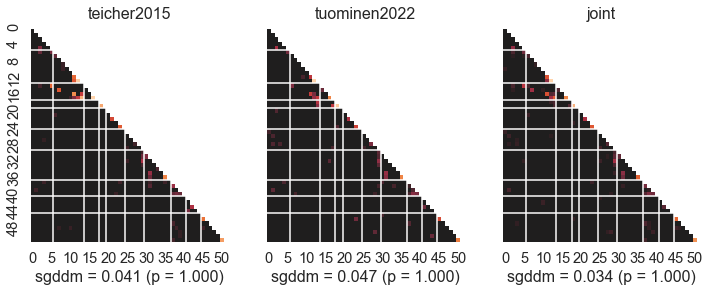

In [3]:
from arviz import hdi

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
studies = ['teicher2015','tuominen2022','joint']

for i, (ax, study) in enumerate(zip(axes, studies)):
    
    ## Load posterior predictive check.
    df = read_csv(os.path.join('stan_results', study, '2plq_m2_ppmc2.csv'))
    
    ## Extract posterior predictive check.
    sgddm, pppv = df.loc[0, ['mu', 'pval']]
    df = df.tail(-1)
    
    ## Construct square matrix.
    smbc = np.zeros((52,52)) * np.nan
    smbc[df.k1, df.k2] = np.where(df.pval > 0.95, df.mu, 0)
    
    ## Plot square matrix.
    sns.heatmap(smbc, vmin=-0.5, vmax=0.5, center=0, mask=np.isnan(smbc), cbar=False, ax=ax)
    for i in np.cumsum([6, 8, 4, 2, 5, 5, 7, 4, 4]): ax.axhline(i, color='w')
    for i in np.cumsum([6, 8, 4, 2, 5, 5, 7, 4, 4]): ax.axvline(i, color='w')
        
    ## Add detail.
    ax.set(xlabel=r'sgddm = %0.3f (p = %0.3f)' %(sgddm, pppv), title=study)

From the above, couple of observations:
- most significant loadings appear to be on diagonal / within page, suggesting there's some local dependence. much of this has to do with semantics. e.g. "being forced" by peers.
- one strong cross-page effect is sexual abuse items of self and siblings. these clearly should be on same scale. same with violence to self and violence to siblings. clearly same origin.
- another strong cross-page effect is feeling afraid of physical violence from peers and actually experiencing physical violence. clearly should also be on same scale.

## Section 2: Factor Loadings

#### Model 2a [Bifactor w/ 10 groups, joint data]

In [4]:
from pandas import Categorical

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load Stan summary.
summary = read_csv(os.path.join('stan_results', 'joint', '2plq_m2_summary.tsv'), sep='\t', index_col=0)

## Extract factor loadings.
loadings = np.zeros((len(design), 2)).astype(float)
for i, j in np.column_stack([np.where(design)]).T:
    loadings[i,int(j > 0)] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
     
## Convert to DataFrame.
design = design.drop(columns='general')
loadings = DataFrame(loadings, columns=['general', 'group'])
loadings.insert(0, 'item', np.arange(len(loadings))+1)
loadings.insert(0, 'subscale', design.columns[np.where(design.values)[-1]])

## Sort DataFrame.
cols = ['PVA','PPhysA','NVEA','SexA','EN','PN','WSV','WIPV','PeerVA','PeerPhysA']
loadings['subscale'] = Categorical(loadings.subscale, categories=cols, ordered=True)
loadings = loadings.sort_values(['subscale','item'])

## Format columns.
loadings['item'] = loadings.item.apply(lambda x: '%0.0f' %x)
loadings['general'] = loadings.general.apply(lambda x: '%0.3f' %x)
loadings['group'] = loadings.group.apply(lambda x: '%0.3f' %x)

## Convert to pivot table.
aggfunc = lambda x: ''.join(x)
loadings.insert(0, 'col', np.arange(len(loadings)) // 26)
loadings.insert(0, 'row', np.arange(len(loadings)) % 26)
loadings = loadings.pivot_table(['subscale','item','general','group'], 'row', 'col', aggfunc=aggfunc).fillna('')
loadings['subscale'] = loadings['subscale'].apply(lambda x: np.where(x == np.roll(x,1), '', x))

# ## Sort columns.
loadings = loadings[['subscale', 'item','general','group']]
loadings = loadings.swaplevel(0, 1, 1)
loadings = loadings[[0,1]]

print(loadings.to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
       0 & \multicolumn{4}{l}{1} \\
subscale & item & general & group &  subscale & item & general & group \\
     PVA &    1 &   0.780 & 0.490 &        EN &   43 &   0.450 & 0.800 \\
\midrule
         &    2 &   0.800 & 0.450 &           &   52 &   0.680 & 0.480 \\
         &    3 &   0.860 & 0.088 &        PN &   44 &   0.600 & 0.690 \\
         &    4 &   0.710 & 0.150 &           &   45 &   0.480 & 0.710 \\
  PPhysA &    6 &   0.760 & 0.230 &           &   46 &   0.760 & 0.180 \\
         &    7 &   0.800 & 0.300 &           &   47 &   0.760 & 0.087 \\
         &    8 &   0.780 & 0.150 &           &   51 &   0.590 & 0.530 \\
         &    9 &   0.430 & 0.840 &       WSV &   15 &   0.660 & 0.280 \\
         &   10 &   0.360 & 0.700 &           &   16 &   0.720 & 0.260 \\
         &   11 &   0.520 & 0.630 &           &   17 &   0.710 & 0.320 \\
    NVEA &    5 &   0.660 & 0.039 &           &   18 &   0.690 & 0.350 \\
         &   40 &   0.690 & 0.02

## Section 3: Variance Decomposition

In [ ]:
studies = ['teicher2015', 'tuominen2022', 'joint']

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

stats = []
for study in studies:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', study, '2plq_m2_summary.tsv'), sep='\t', index_col=0)
    
    ## Extract factor loadings.
    loadings = np.zeros_like(design).astype(float)
    for i, j in np.column_stack([np.where(design)]).T:
        loadings[i,j] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Coefficient omega hierachical.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Preallocate space.
    omega   = np.zeros(len(design.columns))
    omega_s = np.zeros(len(design.columns))
        
    ## Iterate over factors.
    for i, col in enumerate(design.columns):
        
        ## Restrict to items in group.
        L = loadings[design[col]==1]
        
        ## Compute squared sum of factor loadings.
        A = np.square(np.sum(L, axis=0))
        
        ## Compute sum of error variances.
        B = np.sum(1 - np.square(L).sum(axis=1))
        
        ## Compute total variance.
        C = np.sum(A) + B
        
        ## Compute coefficient omega.
        omega[i] = A.sum() / C
        
        ## Compute coefficient omega subscale.
        omega_s[i] = A[i] / C
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Explained common variance.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Compute sum of squares.
    ss = np.square(loadings).sum(axis=0)
    
    ## Compute explained common variance.
    ecv = ss / ss.sum()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### H-index
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Preallocate space.
    H = np.zeros(len(design.columns))
    
    ## Iterate over factors.
    for i, col in enumerate(design.columns):
        
        ## Compute squared loadings.
        s = np.square(loadings[:,i])
        
        ## Compute H-index.
        H[i] = 1. / (1 + 1 / np.sum(s / (1-s)))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Convert to DataFrame.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    stats.append(DataFrame(dict(
        subscale = design.columns,
        study = np.repeat(study, design.columns.size),
        ecv = ecv,
        omega = omega,
        omega_s = omega_s,
        H = H
    )))
    
## Concatenate DataFrames.
stats = concat(stats).replace({'teicher2015':1, 'tuominen2022': 2, 'joint': 3})

## Convert to pivot table.
stats = stats.pivot_table(['omega','omega_s','ecv','H'], 'subscale', 'study')

## Re-organize table.
index = ['general', 'PVA', 'PPhysA', 'NVEA', 'SexA', 'EN', 'PN', 'WSV', 'WIPV', 'PeerVA', 'PeerPhysA']
stats = stats.loc[index, ['omega','omega_s','ecv','H']]

In [ ]:
stats.round(3)

In [ ]:
print(stats.round(3).to_latex())